# Assignment 2b: Pendulum chain

Import modules

In [310]:
# Import modules
import numpy as np
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import time
import cython
from numba import jit
import os
from scipy.optimize import curve_fit
import matplotlib as mpl

Extra functions

In [141]:
# Extra functions

@jit(nopython=True,cache=True)
def TDMA(a,b,c,d):
    # Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
    # From https://stackoverflow.com/questions/8733015/tridiagonal-matrix-algorithm-tdma-aka-thomas-algorithm-using-python-with-nump
    n = len(d)
    w= np.empty(n-1)
    g= np.empty(n)
    p = np.empty(n)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

@jit(nopython=True,cache=True)
def diag_multi_numba(x,y,a):
    # About 40x faster than creating diagonal matrix and dotting. See Optimising.ipnb
    N = len(a)
    z = np.empty(N)
    
    for n in range(1,N-1):
        z[n] = (x[n-1]*a[n-1] + y[n]*a[n+1])
    z[0] = y[0]*a[1]
    z[N-1] = x[N-2]*a[N-2]
    return z

@jit
def roll_1(vect): return np.concatenate((np.array([vect[-1]]),vect[0:len(vect)-1]))

@jit
def roll_0(vect): return np.concatenate((np.array([0]),vect[0:len(vect)-1]))

@jit
def roll_minus_1(vect): 
    # Import a np array and roll the array by -one number
    return np.concatenate((vect[1:],np.array([vect[0]])))

@jit(nopython=True,cache=True)
def important_vals(thetas,omegas):
    # Here I calcuate imporant physics quatities of the pendulum chain, 
    # Kinetic energy (KE,KE_vals), velocities, x and y coordinates (xvals, yvals))
    N = len(thetas)
    KE_vals = np.zeros(N)
    vx_k = np.zeros(N)
    vy_k = np.zeros(N)
    sines = np.zeros(N)
    coses = np.zeros(N)
    velocities = np.zeros(N)
    tot_KE = 0
    tot_PE = 0
    tot_E  = 0
    
    sines = np.sin(thetas)
    coses = np.cos(thetas)
    
    xvals, yvals  = np.cumsum(sines), np.cumsum(-coses)   # Convert and store coordinates
    
    vx_k = np.cumsum(omegas*coses)
    vy_k = np.cumsum(omegas*sines)
    
    velocities = np.sqrt(np.square(vx_k)+np.square(vy_k))
    
    # Using a for loop as numba is better at optimising for loops over vector operations
    # And using numpy's functions will likely create extra temporary arrays that are not needed
    for n in range(N):
        tot_KE += 0.5*(np.square(vx_k[n]) + np.square(vy_k[n])) 
        KE_vals[n] = tot_KE
        
    tot_PE  = np.sum(coses)
    tot_E   = tot_PE + tot_KE   
    return tot_KE,tot_PE, tot_E, velocities, xvals, yvals

@jit
def important_vals_all(thetas,omegas):
    # Calculates the important values of the system, given a dense output
    steps = thetas.shape[0]
    length = thetas.shape[1]
    
    thetas  = np.zeros((steps,length))
    omegas  = np.zeros((steps,length))
    xvals   = np.zeros((steps,length))
    yvals   = np.zeros((steps,length))
    tot_KE  = np.zeros(steps)
    tot_E   = np.zeros(steps)
    tot_PE  = np.zeros(steps)
    
    for iteration in range(steps[0]):
        tot_KE[iteration],tot_PE[iteration],tot_E[iteration], xvals[iteration,], yvals[iteration,] = important_vals(theta,omega)
    return thetas, omegas, xvals, yvals, tot_KE,tot_PE,tot_E



In [206]:
# Inital conditions and saving functions

def pi_raised(angle,N):
    zeta = (angle*np.ones(N))
    zeta = np.concatenate((zeta,np.zeros(N)))
    return zeta

# Return an array of random angles between [-angle,angle]
def random_angle(angle,N):
    np.random.seed(19680801)  # Set random seed for reporducibility
    zeta = (2*np.random.rand(N)-1)*angle
    return np.concatenate((zeta,np.zeros(N)))
    
#ANIMATION
def save_to_file(N,n_step,names):
    path = 'results'
    filename = '{}_pendulums_{}_steps.txt'.format(N,n_step)
    #filename = os.path.join(path,filename)
    np.savez(filename,names.values(),names.keys())
    return

def save_useful_stuff(N,n_step,x,dict):
    names = []
    values= []
    for keys in dict:
        names.append(keys)
        values.append(dict[keys])
    path = 'results'
    # NUmber of pendulums, N, number of integration steps takes, n_step and inital rasied profile by x, multiplied by pi degrees.
    filename = '{}_pendulums_{}_steps_{}_pi_raised'.format(N,n_step,x)
    np.savez_compressed(filename,values)
    return

Main functions

In [143]:
# Main functions

@jit(nopython=True,cache=True)
def RHS(t,zeta):
    # Right hand side function
    N = int(len(zeta)/2)
    
    thetas, omegas = zeta[0:N], zeta[N:]
    first_theta = float(thetas[0])         # Used to calculate R and alpha
    deltas = roll_minus_1(thetas) - thetas  # We want to include all elements for when we create the matricies
    R = np.square(omegas)
    R[0] = R[0] + np.cos(first_theta)
    
    #Create matrix l_0:
    coses = -np.cos(deltas)
    two = 2*np.ones(N)               
    two[0] = 1    # Make the first and last element equal to 1
    
    # Solve for T
    T = TDMA(coses,two,coses,R)
    
    # Create matrix D_0:
    sines = np.sin(deltas)
    
    # Solve for alphas
    alphas = diag_multi_numba(-sines,sines,T)
    alphas[0] = alphas[0] - np.sin(first_theta)
    return np.concatenate((omegas,alphas))

def main_loop(zeta, t_in, t_step,t_max, n_step, N, atol, pre_steps):
    thetas  = np.zeros((n_step,N))
    omegas  = np.zeros((n_step,N))
    theta   = np.zeros(N)
    omega   = np.zeros(N) 
    xvals   = np.zeros((n_step,N))
    yvals   = np.zeros((n_step,N))
    tot_KE  = np.zeros(n_step)
    tot_E   = np.zeros(n_step)
    tot_PE  = np.zeros(n_step)
    velocities  = np.zeros((n_step,N))
    global status  
    status  = []
    
    t = int(t_in)
    iteration = int(0)
    # Initalise the Runge-Kutta function
    integrate = RK45(RHS, t_in, zeta, t_max, max_step=t_step, atol = atol)
    
    # Integrate before
    for n in range(pre_steps):
        integrate.step()
    
    t1 = time.time()
    while iteration < n_step:
        zeta = integrate.y                    # Call current state
        theta = zeta[0:N]                     # Slice to get the thetas, consider storing as a list of numpy arrays, they seem to faster (see Optiming.ipnb)
        thetas[iteration,] = theta

        omega = zeta[N:]
        omegas[iteration,]  = omega

        tot_KE[iteration],tot_PE[iteration],tot_E[iteration], velocities[iteration,], xvals[iteration,], yvals[iteration,] = important_vals(theta,omega)
        status.append(integrate.step())                                 # Integrate
        iteration = iteration + 1
    t2 = time.time()
    print(t2-t1)
    return thetas, omegas,velocities , xvals, yvals, tot_KE,tot_PE,tot_E

def plot(xvals,yvals):
    plt.plot(xvals, yvals)
    plt.xlim([-N,N])
    plt.ylim([-N,N])
    plt.show()
    return

def combine(coordinate):
    return np.concatenate((np.array([0]),coordinate))

# Main code

In [56]:
# Main code
def integrate_for(N,angle,atol,store_vals):
    t_in   = 0      # Initial time
    t_step = np.inf # Time step,  set to a large value to avoid time step issues
    t_max  = np.inf # Final time, Doesn't mean anything in this code, just there to satisfy the RK45
    n_steps= 1000   # Number of steps
    N      = N      # Number of pendulums
    angle  = angle      # Raised by a factor of pi radians, for inital conditions
    atol   = atol
    pre_steps = 0  # Integrate before recording values
    filename = 'potato.mp4'   # Currently not used. For animations... TBC
    np.random.seed(19680801)  # Set random seed for reporducibility

    # Initial condition
    zeta = random_angle(np.pi*angle,N)

    # The main function
    thetas, omegas,velocities , xvals, yvals, tot_KE,tot_PE,tot_E = main_loop(zeta, t_in, t_step,t_max, n_steps, N, atol,pre_steps)

    # Store results
    if store_vals==True:
        names = {'thetas':thetas,'omegas':omegas, 'velocities': velocities}
        save_useful_stuff(N,n_steps,angle,names)
    return tot_KE,tot_PE,tot_E

#integrate_for(1000,0.4,1e-15,False)


# Integrate over 1000 - 3000 pendulums for 5 different angle, and saves the results to a file
for N in range(1000,5000,1000):
    for angle in np.linspace(0.2,1,5):       
        integrate_for(N,angle,1e-10,True)

Integrate over more pendulums

In [36]:
# for N in range(10000,50000,10000):
#     for angle in np.float32(np.linspace(0.2,1,5)):       
#         integrate_for(N,angle,1e-5)

In [38]:
# Used to diagnose problems
# print(len(status))
# print(status[-1])

### Performance
Warning: Takes a couple of minutes

TypeError: only integer scalar arrays can be converted to a scalar index

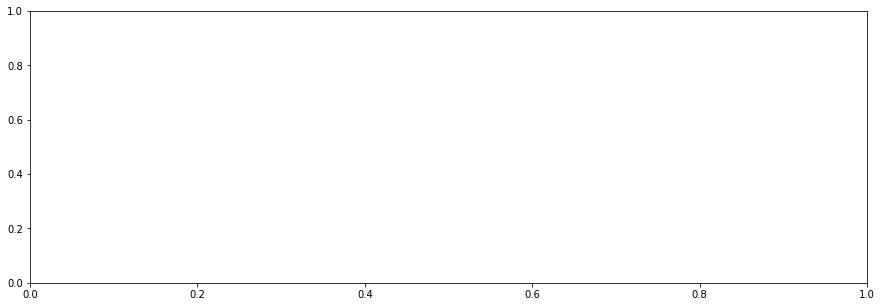

In [98]:
# Computes the time taken for a function for different input values 'space' and prints to a  list
def optimiser(space, fun):
    times = []
    for a in space:

        t1=-time.clock()
        fun(space,1,1e-10,False)
        t1 += time.clock()
        times.append(t1)
    return times

pendulums = np.logspace(1,6,6,dtype=np.int32)

fig, ax = plt.subplots(figsize=(15,5))
ax.loglog(space,optimiser(pendulums,integrate_for))
ax.set_title('Speed of the function diag_multi_numba with different lengths of arrays')
ax.set_xlabel('Length of input array')
ax.set_ylabel('Excution time')

In [39]:
# Create a coloumn of zero to make a plot of the origin, to represent the all pendulums in the chain
column_of_zeros = np.zeros((n_steps,1))

xvals1 = np.ndarray.flatten(np.hstack((column_of_zeros,xvals)))
yvals1 = np.ndarray.flatten(np.hstack((column_of_zeros,yvals)))

plot(xvals1,yvals1) # Plot  all pendulums at once


NameError: name 'n_steps' is not defined

In [115]:
# from scipy.optimize import curve_fit
@jit
def maxwellian(x,a,B,s): return (B)*(x**a)*np.exp(-(x**2)*(s))

def velocity_dist(N,steps,angle,multiplier,N_after,ranges):
    # This function takes a loads a data set, with 'N' pendulums and that was integrated over a number of 'steps'.
    # Then is plots a density normalised, velocity histograms starting after the 'N_after' step, with a range of
    # 'ranges' and the 'multiplier'. Then fits a general boltzmann's curve
    
    # The 'multiplier' variable is there to help the curve fitting (i believe that if the parameters of the curve fitting 
    # function 'maxwellian' are too far off 1, then the curve fitting function fails)
    
    names = ['thetas','omegas', 'velocities']             # Shows what the array in npzfiles are, as the 
                                                          # npzfile doesn't save the names of arrays
        
    npzfile = np.load('{}_pendulums_{}_steps_{}_pi_raised.npz'.format(N,steps,angle))   # Load files
    
    velocities_normed = npzfile['arr_0'][names.index('velocities')]
    
    velocities_normed = velocities_normed/np.max(velocities_normed)
    
    n, bins, patches = plt.hist(multiplier*np.ndarray.flatten(velocities_normed[N_after:]),range=ranges, bins=80,density=True)

    popt, pconv  = curve_fit(maxwellian, bins[1:],n,absolute_sigma=True)

    plt.plot(bins[1:],maxwellian(bins[1:],popt[0],popt[1],popt[2]),'--',lw=3)
    plt.xlabel('Velocities (no units)')
    plt.ylabel('Frequency')
    plt.title('Normalised histogram of velocities after the {} step and {} pendulums'.format(N_after,N))
    plt.text(40,0.03,'a = {:.2f}'.format(popt[0]))
    plt.legend(['Fitting','Histogram'])
    plt.show()
    #plt.text( '$\sum_{i=0}^\infty x_i$', fontsize=20)
    print(popt)
    return 

Velocitiy distributions of 1000 pendulum chains, with random inital conditions, in the range $|\theta_i|<a$, where $a =0.2,0.4,0.6$

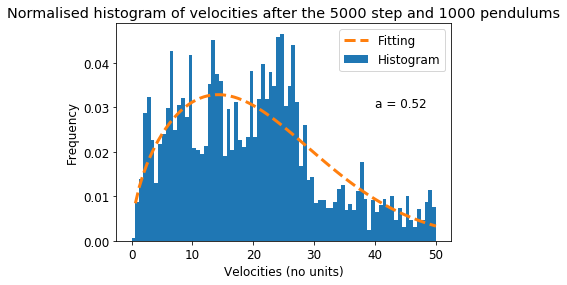

[0.51846621 0.01074802 0.00128212]


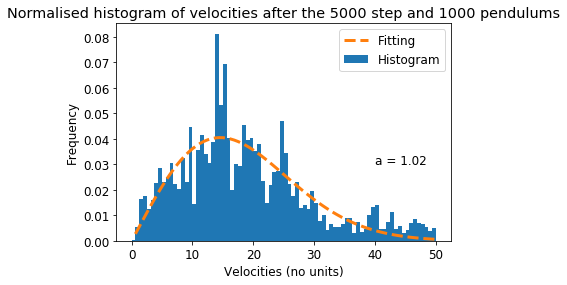

[1.0211118  0.00437542 0.00240705]


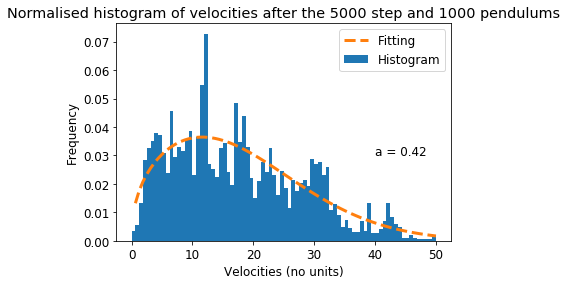

[0.41912768 0.01608331 0.00155428]


In [313]:
velocity_dist(1000,6000,0.6,250,5000,[0,50])
velocity_dist(1000,6000,0.4,200,5000,[0,50])
velocity_dist(1000,6000,0.2,150,5000,[0,50])

The value $a$ shows the variable in the fitting of the Maxwell-Boltzman curve (see sect 3.2 of the report). We can see that it does not stay constant, it varies considerably.

### Animating the pendulums

6.128971576690674


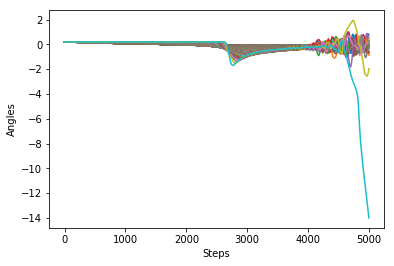

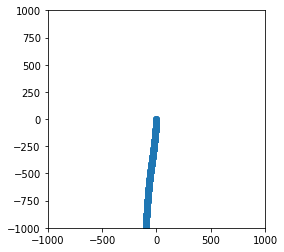

In [189]:
def animate_pendulum(N,x,y,filename,steps,num_frames):
#     t = np.linspace(0, 10, 200)
#     p = integrate_pendulum(n, t)
#     x, y = get_xy_coords(p)
    fig = plt.figure()
    ax = plt.axes(xlim=(-N,N),ylim = (-N,N))
    ax.set_aspect('equal')

    line, = ax.plot([], [], 'o-', lw=0.1)

    def init():
        line.set_data([], [])
        return line,

    @jit
    def animate(frame):
        line.set_data(x[frame,], y[frame,])
        return line,
    
    anim = animation.FuncAnimation(fig, animate, frames=np.around(np.linspace(0,len(x)-1,num=int(num_frames)),decimals=0).astype(np.int), blit=True, init_func=init)

    anim.save(filename, fps=30, extra_args=['-vcodec', 'libx264'])
    return

def animate(N,steps,angle,filename,num_frames,intial_conditions):
# This function takes a loads a data set, with 'N' pendulums and that was integrated over a number of 'steps'.
# Then is plots an animation of the data, with num_frames number of frames, with filename, saved in the root folder, at 30 fps
# It also plot the angles at each step, just to look pretty
# It also takes in an inital_condition funtion, that creates the inital setup for the pendulum

    zeta = intial_conditions(angle,N)
    # Run the integration scheme
    thetas, omegas,velocities , xvals, yvals, tot_KE,tot_PE,tot_E = main_loop(zeta,0,np.inf,np.inf,steps,N,1e-5,0)
    
    plt.plot(thetas)
    plt.xlabel('Steps')
    plt.ylabel('Angles')
    plt.show()
    
    animate_pendulum(N,xvals,yvals,filename,steps,num_frames)
    
    return

Entire pendulum raised by $0.2\pi$ rads.

6.500893831253052


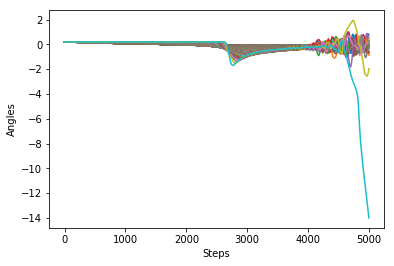

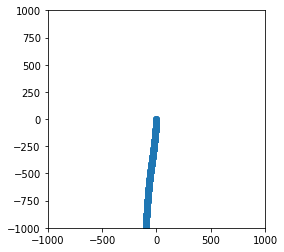

In [190]:
animate(1000,5000,0.2,'potato.mp4',300,pi_raised)

In the first plot, we see towards the end that the velocities of all the pendulums increases. Lets try for a larger angle.

6.317877292633057


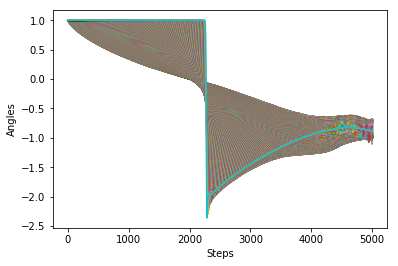

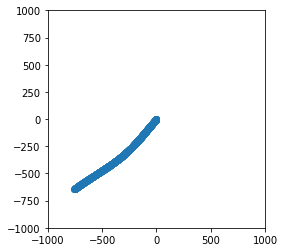

In [191]:
animate(1000,5000,1,'potato.mp4',300,pi_raised)

The inflection point corresponds to the pendulum crossing the y=0 axis. The general trend seems to be: energy likes to spread out between the pendulums. It suggests that if one pendulum is moving fast, then the energy will transfer to the pendulums below it.

### Total energy of sytem

12.26985216140747


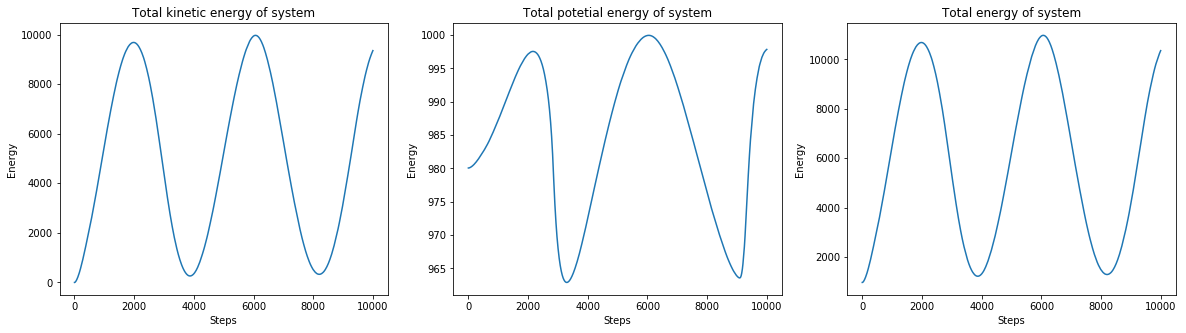

In [202]:
 def create_energy_plots(N,steps,angle,intial_conditions):
# Creates energy plots baised on number of pendulums, number of steps, angle raised of inital condtions and type of initak condition

    zeta = intial_conditions(angle,N)
    # Run the integration scheme
    thetas, omegas,velocities , xvals, yvals, tot_KE,tot_PE,tot_E = main_loop(zeta,0,np.inf,np.inf,steps,N,1e-8,0)

    fig, ax = plt.subplots(1,3,figsize=(20,5))

    names=['Total kinetic','Total potetial','Total']
    plotting = [tot_KE,tot_PE,tot_E]

    for x in range(len(plotting)):
        ax[x].plot(plotting[x])
        ax[x].set_xlabel('Steps')
        ax[x].set_ylabel('Energy')
        ax[x].set_title('{} energy of system'.format(names[x]))
    plt.show()
    return
    
create_energy_plots(1000,10000,0.2,pi_raised)

Some strange behavior... Strange that my total energy doesn't remain constant and varies quite considerably. After checking the calculation, I still can't seem to find the cause for this.

Lets try for different angles

13.046174764633179


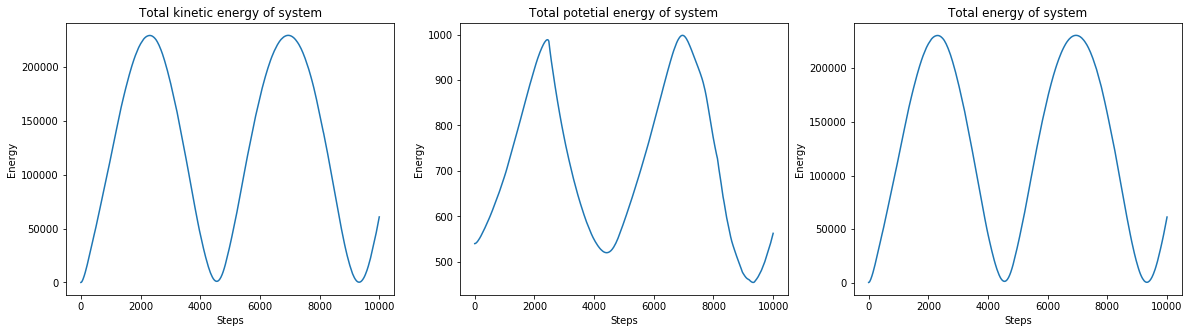

In [204]:
create_energy_plots(1000,10000,1,pi_raised)

Lets try for less pendulums and same integration time

2.651151180267334


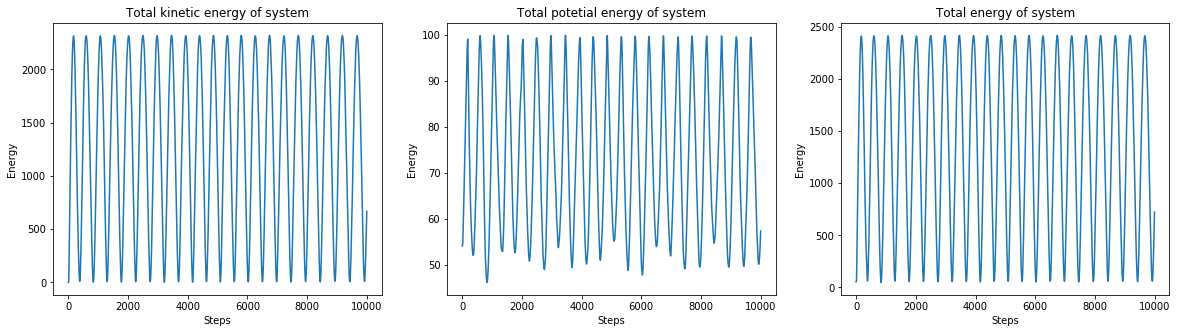

In [209]:
create_energy_plots(100,10000,1,pi_raised)

Let's compare the total energy plots for different number of pendulums.

In [307]:
 def create_energy_plots_pendulums(steps,angle,intial_conditions,start,stop,nums):
# Creates energy plots baised on number of pendulums, number of steps, angle raised of inital condtions and type of initak conditions

    array = np.logspace(start,stop,num=nums,dtype=np.int)
    print(array)
    
    fig, ax = plt.subplots(1,int(nums),figsize=(23,5))

    for x in range(len(array)):
        # Run the integration scheme
        zeta = intial_conditions(angle,array[x])
        thetas, omegas,velocities , xvals, yvals, tot_KE,tot_PE,tot_E = main_loop(zeta,0,np.inf,np.inf,steps,array[x],1e-8,0)
        
        ax[x].plot(tot_E)
        ax[x].set_xlabel('Steps')
        ax[x].set_ylabel('Energy')
        ax[x].set_title('Total energy of system {} pendulums'.format(array[x]))
    plt.show()
    return

[  10  100 1000]
0.22181105613708496
0.24450373649597168
1.2145147323608398


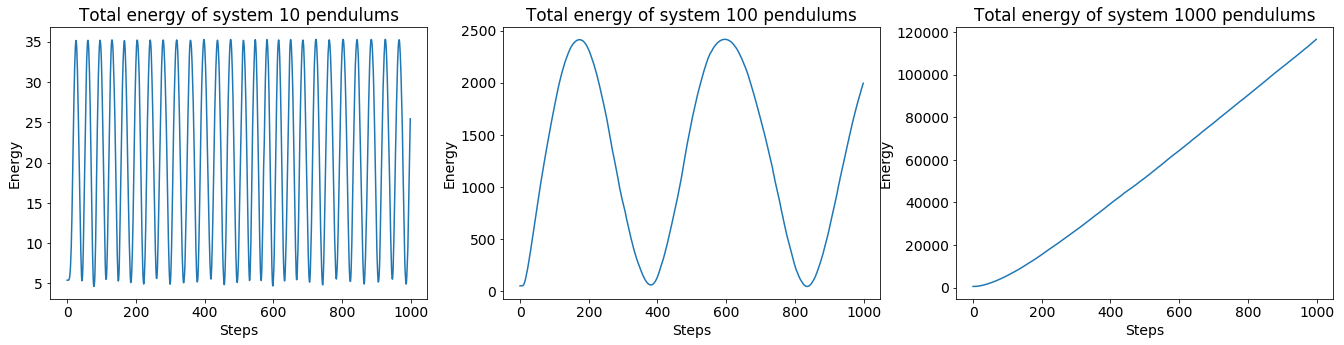

In [312]:
mpl.rcParams['font.size'] = 14

create_energy_plots_pendulums(1000,1,pi_raised,1,3,3)

mpl.rcParams['font.size'] = 12

So, it is clear, that the number of pendulums affects this frequency in energy. Lets plot a FFT of the above to see if we can find a pattern.

In [285]:
def create_energy_plots_pendulums_FFT(steps,angle,intial_conditions,start,stop,nums):
# Creates energy plots baised on number of pendulums, number of steps, angle raised of inital condtions and type of initak conditions
    f_max = 1e10
    dt = 1/(2*f_max) # 6.1e-05 seconds (using Sampling Theorem)
    array = np.logspace(start,stop,num=nums,dtype=np.int)
    
    fig, ax = plt.subplots(1,int(nums),figsize=(30,5))

    for x in range(len(array)):
        # Run the integration scheme
        zeta = intial_conditions(angle,array[x])
        thetas, omegas,velocities , xvals, yvals, tot_KE,tot_PE,tot_E = main_loop(zeta,0,np.inf,np.inf,steps,array[x],1e-8,0)
        
        y = np.fft.rfft(tot_E)
        f = np.fft.rfftfreq(len(tot_E),d=dt)
        
        x1 = x + int(nums)
        ax[x].semilogx(f,np.abs(y),color='green')
        ax[x].set_xlabel('$f$')
        ax[x].set_title('FFT of energy plots for {} pendulums'.format(array[x]));
        
    plt.show()
    return

0.13802003860473633
0.16278672218322754
0.26942944526672363


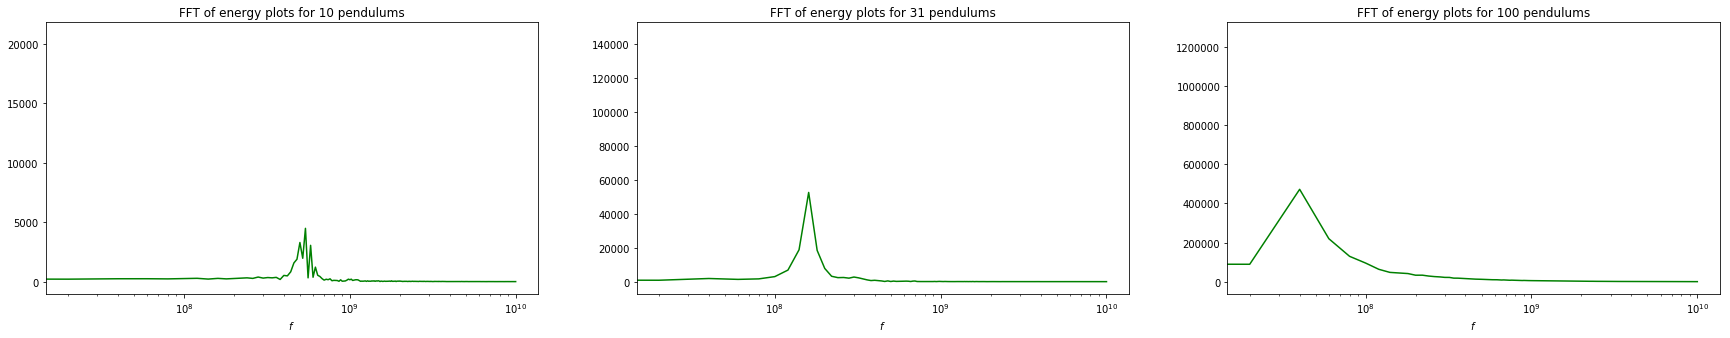

In [286]:
create_energy_plots_pendulums_FFT(1000,1,pi_raised,1,2,3)

And some more, over different ranges

2.0899953842163086
3.208643674850464
5.901244640350342


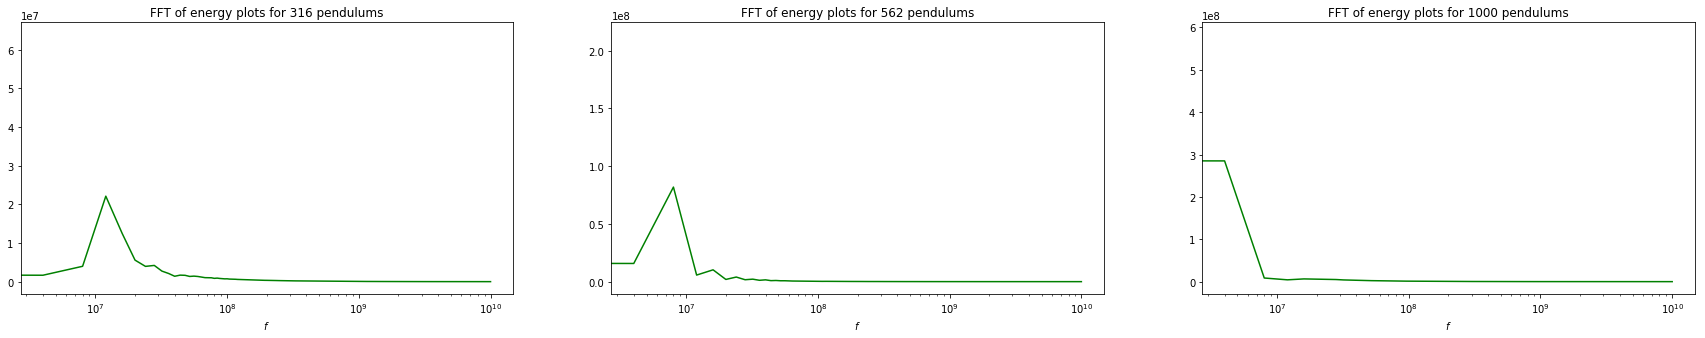

In [282]:
create_energy_plots_pendulums_FFT(5000,1,pi_raised,2.5,3,3)

We can definately see the frequecy increase here. On the plot on the right, the frequency increases so rapidly, that the integration time is too small for the FFT to accurately measure the frequency. Unfortunately, my laptop/tablet/surface only has 4gb of ram, so I get an error when I integrate over larger times.

We get the same thing, lets try for a random angle inital condition. This one takes a bit longer to complie.

15.58930516242981


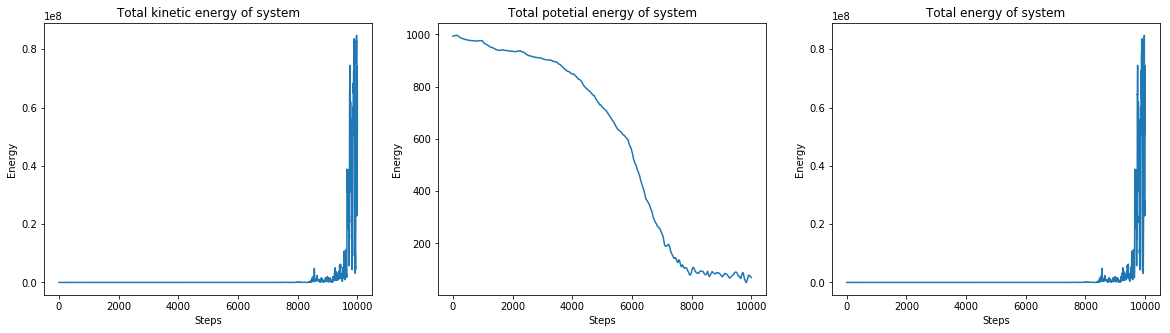

In [207]:
create_energy_plots(1000,10000,0.2,random_angle)

Much stranger??

The next step would be to use a peak finder on the fourier transformed energies, to make a plot of the the frequency in the total energy plots against number of pendulums.